# Free Final Time Optimal Control Problem

In [1]:
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

Consider a simple one-dimensional double integrator system with dynamics:
\begin{equation}
\ddot{x} = u,
\end{equation}
where $u$ is the control input.
Suppose we wish to minimize the cost:
\begin{equation}
J(x,u) = \frac{1}{2}\alpha t_f^2 + \int_0^{t_f} \frac{1}{2} \beta u^2(t) dt,
\end{equation}
with boundary conditions $x(0) = 10$, $\dot{x}(0) = 0$, $x(t_f) = 0$, and $\dot{x}(t_f) = 0$.

This is a free final time problem, meaning the final time $t_f$ is a variable in the optimization problem. By constructing the Hamiltonian, we will find that the necessary optimality conditions (NOCs) are (construct the Hamiltonian and derive these conditions yourself for practice):
\begin{equation}
\dot{x}^*_1 = x^*_2, \quad \dot{x}^*_2 = u^*, \quad \dot{p}^*_1 = 0, \quad \dot{p}^*_2 = -p^*_1, \quad 0 = \beta u^* + p^*_2,
\end{equation}
where we have converted the dynamics into a set of first-order differential equations using $x_1 = x$ and $x_2 = \dot{x}$ and where $p_1$ and $p_2$ are the costate variables.
From the last condition, we can algebraically derive that $u^* = -\frac{1}{\beta}p^*_2$, which we can substitute into the other necessary conditions to produce the set of $2n$ differential equations.

In addition to the boundary conditions on the state, we also have the additional boundary condition:
\begin{equation}
\frac{1}{2}\beta u^*(t_f)^2 + p_1^*(t_f)x_2^*(t_f)+p_2^*(t_f)u^*(t_f) + \alpha t_f = 0.
\end{equation}

The challenge with these NOCs is now putting it into a standard form that `scipy.integrate.solve_bvp` can solve. Specifically, we don't now the final time but we need to be able to specify the range of time for the solver to use. We can get around this issue through a "trick" of introducing the final time as a new state variable with the trivial dynamics $\dot{t_f} = 0$. We can then reformulate NOCs with a new independent state variable $\tau = \frac{t}{t_f}$ and rewrite the conditions as:
\begin{equation}
\frac{dx^*_1}{d\tau} = t^*_f x^*_2, \quad \frac{dx^*_2}{d\tau} = t^*_f u^*, \quad \frac{dp^*_1}{d\tau} = 0, \quad \frac{dp^*_2}{d\tau} = -t^*_f p^*_1.
\end{equation}

Then we can simply specifiy for the solver to operate over the time interval $[0,1]$.

In [2]:
def free_final_time_double_integrator(t, z, β=1):
    """
    Set of first-order differential equations that describe the necessary optimality 
    conditions for the double integrator free final time optimal control problem.
    
    Parameters
    ----------
    t : time
    z : state vector, [x1, x2, p1, p2, tf]
    β : control cost weight

    Returns
    -------
    dz/dt : time derivative of the state
    """
    x1, x2, p1, p2, tf = z
    u = -p2 / β
    return tf * np.array([x2, u, np.zeros_like(t), -p1, np.zeros_like(t)])

def free_final_time_double_integrator_bcs(z0, zf, α=1, β=1):
    """
    Boundary conditions for the necessary optimality conditions for the double integrator 
    free final time optimal control problem.
    
    Parameters
    ----------
    z0 : initial state conditions
    zf : final state conditions
    α : final time weight
    β : control cost weight

    Returns
    -------
    l(z0, zf) : boundary conditions in the standard form  l(z0, zf) = 0
    """
    x1_0, x2_0, p1_0, p2_0, tf_0 = z0
    x1_f, x2_f, p1_f, p2_f, tf_f = zf
    u_f = -p2_f / β
    return np.array([x1_0 - 10, x2_0, x1_f, x2_f, 0.5 * β * u_f**2 + p1_f * x2_f + p2_f * u_f + α * tf_f])

Solver success: True
Computed optimal final time: 4.477721988606323


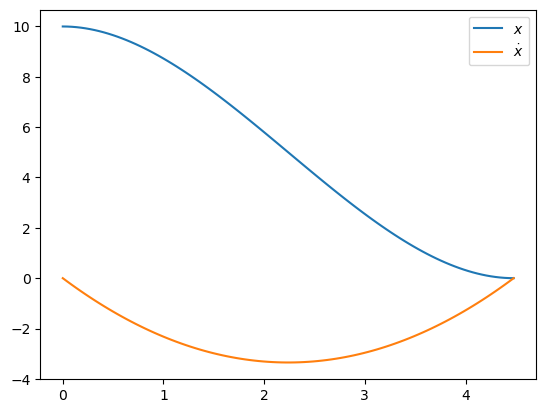

In [3]:
# Specify problem parameters
α = 1
β = 1
N = 20

# Build initial time mesh and initial guess for state variables
tau_mesh = np.linspace(0, 1, N + 1)
z_initial_guess = np.array([np.linspace(10, 0, N + 1),
                  np.zeros(N + 1),
                  np.zeros(N + 1),
                  np.zeros(N + 1),
                  np.ones(N + 1)])

# Solve TPBVP
sol = solve_bvp(
        fun=lambda t, z : free_final_time_double_integrator(t, z, β=β), 
        bc=lambda z0, zf : free_final_time_double_integrator_bcs(z0, zf, α=α, β=β), 
        x=tau_mesh,
        y=z_initial_guess)
print(f"Solver success: {sol.success}")
tf = sol.y[-1, 0]
print(f"Computed optimal final time: {tf}")

# Plot solution, note we have to convert back from the normalized time, τ, to the real time
tau_plot = np.linspace(0, 1, 100)
t_plot = tf * tau_plot
z_plot = sol.sol(tau_plot)
plt.plot(t_plot, z_plot[0,:], label=r"$x$")
plt.plot(t_plot, z_plot[1,:], label=r"$\dot{x}$")
plt.legend()
plt.show()